>*NOM & PRENOM :* MEZUI ROTIMI Prince

>*FILIERE :* ENSAI - MASTERE SPECIALISE DATA SCIENCE POUR LA CONNAISSANCE CLIENT

>*MATIERE :* Traitement Automatique des Langues


# PARTIE A : Classification de documents

## Installation des packages

In [ ]:
import pandas as pd
import numpy as np

import json
from pprint import pprint

import spacy

import feedparser as fp
import ssl
import newspaper as np

from collections import Counter, defaultdict
from itertools import combinations, islice

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Bidirectional, Attention

from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.pyplot as plt

In [5]:
!python -m spacy download fr_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 17.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Download the en_core_web_md corpus
process = spacy.load('fr_core_news_md') # pipeline

## Récupération des arcticles

In [ ]:
!wget https://people.irisa.fr/Guillaume.Gravier/teaching/ENSAI/data/francetvinfo.json
!wget https://people.irisa.fr/Guillaume.Gravier/teaching/ENSAI/data/tvinfo-sources.json

--2024-12-31 08:21:47--  https://people.irisa.fr/Guillaume.Gravier/teaching/ENSAI/data/francetvinfo.json
Resolving people.irisa.fr (people.irisa.fr)... 131.254.254.107
Connecting to people.irisa.fr (people.irisa.fr)|131.254.254.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5887584 (5.6M) [application/json]
Saving to: ‘francetvinfo.json’

francetvinfo.json   100%[===================>]   5.61M  2.76MB/s    in 2.0s    

2024-12-31 08:21:50 (2.76 MB/s) - ‘francetvinfo.json’ saved [5887584/5887584]

--2024-12-31 08:21:50--  https://people.irisa.fr/Guillaume.Gravier/teaching/ENSAI/data/tvinfo-sources.json
Resolving people.irisa.fr (people.irisa.fr)... 131.254.254.107
Connecting to people.irisa.fr (people.irisa.fr)|131.254.254.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179 [application/json]
Saving to: ‘tvinfo-sources.json’

tvinfo-sources.json 100%[===================>]     179  --.-KB/s    in 0s      

2024-12-31 08:21:50 (6

1. En vous aidant de l’exemple ci-dessus, écrire un premier programme qui realise les operations suivantes :

• lecture de la base de donnees existantes francetvinfo.json – regardez au passage la structure de ce fichier json et les informations qu’il contient

• identifier les informations disponibles dans le flux RSS de l’exemple ci-dessus et les elements correspondants dans la structure de donnees retournees par fp.parse

• pour chacun des flux RSS listes dans le fichier tvinfo-sources.json :

– lire les donnees du flux RSS

– scanner les articles et reperer ceux qui ne sont pas deja presents dans la base de donnees

In [26]:
# Fonction d'enregistrement des acrticles
def load_articles_FranceTV(json_data):
    """
    Fonction qui charge les données d'un fichier JSON structuré contenant des articles provenant de FranceTV et retourne un DataFrame structuré contenant les informations principales.

    ! Attention : Ce code est spécifiquement adapté à la structure du fichier JSON FranceTV.

    Parameters:
        json_data (dict): Dictionnaire contenant les données des articles issues du fichier JSON FranceTV.
                          Chaque clé correspond à un identifiant unique d'article, et les valeurs sont des dictionnaires contenant les informations sur l'article.

    Returns:
        pandas.DataFrame: Un DataFrame contenant les colonnes suivantes :
                          - 'id' : Identifiant unique de l'article
                          - 'title' : Titre de l'article
                          - 'date' : Date de publication de l'article
                          - 'category' : Catégorie de l'article
                          - 'content' : Contenu textuel de l'article
                          - 'image_link' : Lien vers l'image associée à l'article
    """
    col = ['id'
            , 'title'
            , 'date'
            # , 'author'      # on a jamais l'info donc on peut ignorer
            , 'category'
            , 'content'
            , 'image_link'
       ]
    df = pd.DataFrame(columns=col)

    for key, value in france_tv.items():
      df = pd.concat([df,
                      pd.DataFrame([[key
                                    , value['title']
                                    , value['date']
                                    # , value['author']
                                    , value['category']
                                    , value['content']
                                    , value['image_link']
                                    ]]
                                    , columns=col)
                      ],axis=0)
    return df

In [9]:
# Chargement la base de données existante - FranceTV
with open('francetvinfo.json', 'r') as f:
  france_tv = json.load(f)

# Affichage d'un article
print("--- Structure de francetvinfo.json ---")
for key, value in france_tv.items():
  pprint(france_tv[key])
  break;
print()

# Enregistrement des articles FranceTV
data_articles = load_articles_FranceTV('francetvinfo.json')

--- Structure de francetvinfo.json ---
{'author': [],
 'category': 'france',
 'content': 'Beaucoup de maires et de secrétaires de mairie ont rencontré au '
            'cours de leurs mandats des problèmes de violence, essentiellement '
            "verbale. C'est le cas de Claire. Un jour, un homme est entré dans "
            "son bureau et a frappé très fort sur son bureau pour l'intimider. "
            '"J\'ai réagi à l\'instinct, j\'ai essayé de discuter, mais ça '
            "s'est envenimé. Heureusement qu'une dame est arrivée à la "
            'permanence et a menacé d\'appeler la gendarmerie", raconte Claire '
            'Carrère-Godebout, maire (SE) de Graveron-Sémerville (Eure).\n'
            '\n'
            'Des professeurs de karaté et un psychologue\n'
            '\n'
            'La plupart de ces élus ne savent pas comment se comporter face à '
            "une situation conflictuelle. Alors, l'Association des maires "
            "ruraux de l'Eure les initie à l

2. Pour l’un des articles de votre flux RSS, regardez le code HTML de la page web. Pouvez-vous identifier les zones contenant le titre de l’article ? le texte de l’article ? Que faudrait-il faire pour recuperer le texte de l’article ? En quoi le recours a la librairie newspaper est-il utile ?


*La librairie **newspaper** simplifie grandement l'extraction du texte des articles. Grâce à ses fonctionnalités dédiées, on peut récupérer automatiquement les contenus des articles sans avoir à inspecter manuellement chaque page pour identifier les zones HTML contenant les informations souhaitées. Cela fait gagner du temps et permet de gérer les variations de structure HTML entre différents sites de manière efficace.*

3. Reprendre votre programme de scrapping et le completer de maniere a mettre a jour votre base de donnees avec le texte des articles du flux RSS et le lien vers l’image illustrant l’article lorsqu’il y en a une. Vous pouvez inclure d’autres informations qui vous semblent utile pour un
traitement ulterieur. On attend pour cette question une fonction qui prend en entree les flux RSS a lire et la base de donnees a mettre a jour et qui retourne la base de donnees mise a jour

In [10]:
# Fonction de mise à jour de la base articles
def update_articles_db(rss_sources, existing_db):
    """
    Met à jour une base de données d'articles en intégrant les nouveaux articles trouvés dans les flux RSS fournis.

    Parameters:
        rss_sources (dict): Dictionnaire contenant les flux RSS à lire. Chaque clé correspond à une catégorie, et chaque valeur est l'URL d'un flux RSS associé.
        existing_db (pandas.DataFrame): DataFrame contenant la base de données existante des articles.
                                        Doit inclure une colonne 'id' pour identifier les articles de manière unique.

    Returns:
        pandas.DataFrame: Base de données mise à jour avec les nouveaux articles ajoutés, incluant les colonnes :
            - 'id' : Identifiant unique de l'article (utilisant l'URL de l'article comme ID).
            - 'title' : Titre de l'article.
            - 'date' : Date de publication de l'article (si disponible dans le flux RSS).
            - 'category' : Catégorie associée au flux RSS d'où provient l'article.
            - 'content' : Contenu textuel complet de l'article (extrait via `newspaper`).
            - 'image_link' : Lien vers l'image principale de l'article (extrait via `newspaper`).
    """
    # Parcourir les flux RSS
    for category, rss_url in rss_sources.items():
        feed = fp.parse(rss_url)

        for entry in feed.entries:
            # Vérifier si l'article existe déjà dans la base de données
            if entry.link not in existing_db['id'].values:
                try:
                    # Utiliser la librairie newspaper pour télécharger et parser l'article
                    article = np.Article(entry.link)
                    article.download()
                    article.parse()

                    # Ajouter le nouvel article à la base de données
                    new_article = pd.DataFrame([{
                        'id': entry.link,
                        'title': entry.title,
                        'date': entry.published if 'published' in entry else None,
                        'category': category,
                        'content': article.text,
                        'image_link': article.top_image
                    }])

                    existing_db = pd.concat([existing_db, new_article], ignore_index=True)

                except Exception as e:
                    print(f"Erreur lors du traitement de l'article {entry.link}: {e}")

    return existing_db


In [11]:
# Chargement de la liste des flux RSS - TVinfo-Sources
with open('tvinfo-sources.json', 'r') as f:
  src = json.load(f)

# Affichage du contenu de json
print("--- Structure de tvinfo-sources.json ---")
pprint(src)
print()

# Affichage des info disponinles dans le flux RSS
print("--- Informations disponibles dans le flux RSS ---")
for key, value in src.items():
  dt = fp.parse(value)
  for item in dt.entries:
    article = np.Article(item.link)
    article.download()
    article.parse()
    break
  break
pprint(item)

# Enregistrement des nouveaux articles
data_articles = update_articles_db(src, data_articles)


--- Structure de tvinfo-sources.json ---
{'economie': 'https://www.francetvinfo.fr/economie/entreprises.rss',
 'europe': 'https://www.francetvinfo.fr/monde/europe.rss',
 'france': 'https://www.francetvinfo.fr/france.rss'}

--- Informations disponibles dans le flux RSS ---
{'guidislink': False,
 'id': 'https://www.francetvinfo.fr/france/auvergne-rhone-alpes/rhone/enquete-ouverte-apres-l-incendie-d-un-pylone-de-telecommunication-prive-800-000-foyers-de-television-dans-le-rhone_6986552.html#xtor=RSS-3-[general]',
 'link': 'https://www.francetvinfo.fr/france/auvergne-rhone-alpes/rhone/enquete-ouverte-apres-l-incendie-d-un-pylone-de-telecommunication-prive-800-000-foyers-de-television-dans-le-rhone_6986552.html#xtor=RSS-3-[general]',
 'links': [{'href': 'https://www.francetvinfo.fr/france/auvergne-rhone-alpes/rhone/enquete-ouverte-apres-l-incendie-d-un-pylone-de-telecommunication-prive-800-000-foyers-de-television-dans-le-rhone_6986552.html#xtor=RSS-3-[general]',
            'rel': 'alterna

4. Les images etant susceptibles de ne pas rester sur le site web, il faudrait idealement en faire une copie locale dans notre base de donnees pour pouvoir s’y refererer ulterieurement. Comment procederiez-vous pour ce faire ? On ne vous demande pas de faire le programme correspondant, juste de donner l’idee de comment vous vous y prendriez.

*On pourrait créer un dossier local dédié, pour y stocker les images. Pour chaque article, on téléchargerait l'image via son URL stocké et on l'enregistrerait dans ce dossier avec un nom unique basé sur l’ID de l'article stocké.*

5. Donnez une idee d’une (ou plusieurs) autre(s) source(s) que l’on pourrait-on ecouter pour collecter des informations complementaires sur ces articles ? Sans donner le code, donnez une idee de ce que l’on pourrait collecter sur ces sources et de la/des librairie(s) qui pourrai(en)t nous aider en cela.

*On pourrait écouter des sources comme les fils RSS d'autres médias  (Le Monde, Libération, BBC, Les Échos pour l'économie, Science et Vie pour la science). On pourrait enrichier notre analyse en y extrayant des informations comme des perspectives différentes sur des sujets similaires, des données économiques ou des faits scientifiques.*

In [12]:
# Affichage de quelques lignes de la base articles
pd.concat([data_articles.head(), data_articles.tail()])

,id,title,date,category,content,image_link
0,https://www.francetvinfo.fr/sante/prevention/e...,"Violences contre les maires : dans l'Eure, des...",2020-01-19T16:31:16,france,Beaucoup de maires et de secrétaires de mairie...,https://www.francetvinfo.fr/image/75rt1bxrp-70...
1,https://www.francetvinfo.fr/france/video-sur-l...,VIDEO. Sur le dos d'un aigle pêcheur au-dessus...,2020-01-19T16:30:02,france,"#AlertePollution Rivières ou sols contaminés, ...",https://www.francetvinfo.fr/image/75rt1br51-6d...
2,https://www.francetvinfo.fr/societe/video-mass...,"VIDEO. Dans le massif du Mont-Blanc, la hausse...",2020-01-19T16:29:55,france,"#AlertePollution Rivières ou sols contaminés, ...",https://www.francetvinfo.fr/image/75rt1bbzf-01...
3,https://www.francetvinfo.fr/replay-magazine/fr...,"""13h15 le dimanche"". Le Mont-Blanc, un mythe é...",2020-01-19T16:29:48,france,Point culminant de la chaîne des Alpes avec un...,https://www.francetvinfo.fr/image/75rszkkvp-24...
4,https://www.francetvinfo.fr/societe/loi-de-bio...,Loi de bioéthique : les opposants à la PMA man...,2020-01-19T16:08:10,france,"Des associations catholiques, des jeunes, des ...",https://www.francetvinfo.fr/image/75rt1bbs2-3f...
2152,https://www.francetvinfo.fr/economie/entrepris...,L'entreprise Cafés Legal située au Havre en li...,"Tue, 17 Dec 2024 19:54:02 +0100",economie,L'entreprise Cafés Legal située au Havre (Sein...,https://www.francetvinfo.fr/pictures/rKac5NSPG...
2153,https://www.francetvinfo.fr/economie/energie/e...,"Énergies renouvelables : ""Il va falloir simpli...","Tue, 17 Dec 2024 09:55:24 +0100",economie,"Investir en France est ""un enfer"" a déclaré la...",https://www.francetvinfo.fr/pictures/1OMg6jdoJ...
2154,https://www.francetvinfo.fr/replay-radio/le-br...,Le japonais SoftBank annonce investir cent mil...,"Tue, 17 Dec 2024 08:01:06 +0100",economie,Le groupe technologique japonais SoftBank prom...,https://www.francetvinfo.fr/pictures/OBVuKAG_u...
2155,https://www.francetvinfo.fr/economie/entrepris...,Duralex : le succès de la boutique des salarié...,"Mon, 16 Dec 2024 16:59:33 +0100",economie,La marque de verre Duralex a lancé son premier...,https://www.francetvinfo.fr/pictures/S0YW5stjP...
2156,https://www.francetvinfo.fr/replay-radio/le-de...,"La France creuse son déficit à 6 % en 2024, un...","Mon, 16 Dec 2024 10:11:40 +0100",economie,La loi spéciale de finances est discutée lundi...,https://www.francetvinfo.fr/pictures/s-RN35wgb...


**Commentaire :**

*En mettant à jour notre base de données à des jours différents on constate qu'elle change. Ce qui est logique puisqu'on scrappe des articles actuels. Par exemple, en période d'élections on s'attendra à avoir des articles à ce sujet plutôt.*

*On s'attend donc aussi à avoir des conclusions dans la suite de notre travail qui peuvent changer.*

## Extractions d'informations

### Extraction des entités nommées

7. A quoi correspondent les etiquettes IOB utilisees ? Expliquer brievement une technique (description de la tache, du modele) pour la detection des entites nommees

* *Les étiquettes IOB sont un format standard utilisé pour annoter les
entités nommées dans les textes. Chaque token se voit attribuer une des trois étiquettes suivantes :*

  *I (Inside) : Le token fait partie d'une entité nommée.*

  *O (Outside) : Le token n'est pas associé à une entité nommée.*

  *B (Begin) : Le token est le premier élément d'une entité nommée, lorsqu'elle suit immédiatement une autre entité nommée de même type.*


* *Une technique efficace pour détecter les entités nommées repose sur les réseaux neuronaux BiLSTM combinés avec un CRF :*

  *BiLSTM : Capture le contexte des mots dans les deux directions (gauche-droite et droite-gauche) pour une meilleure compréhension du texte.*

  *CRF (Conditional Random Fields) : Garantit des séquences d’étiquettes cohérentes, en prenant en compte les relations entre les étiquettes (par exemple, éviter qu’une étiquette I-PER suive directement une B-LOC).*

*Cette combinaison permet une extraction précise et cohérente des entités nommées, même dans des textes complexes. [[source](https://www.depends-on-the-definition.com/sequence-tagging-lstm-crf/)]*

8. Ecrire un programme qui traite l’ensemble des textes que vous aurez charge depuis le fichier francetvinfo.json et stock pour chaque article les entites trouvees et les informations afferentes (type, span). On cherchera a optimiser le temps de traitement en utilisant la commande pipe et en n’activant dans la chaıne de traitement spaCy uniquement les traitemens necessaires pour la
tˆache a effectuer. On rappelle que chaque article ne devra etre traite qu’une et une seule fois par spaCy pour extraire les informations necessaires : la suite exploite le resultat de cette analyse mais ne requiert pas de refaire l’analyse linguistique de la phrase (on sera cependant amene a reprendre cette phase d’analyse pour inclure de nouvelles informations par la suite).

In [27]:
def extract_entities(documents):
    """
    Extrait les entités nommées des textes fournis à l'aide d'un pipeline NLP.

    Cette fonction traite les textes par lots de 50 documents, utilise un pipeline NLP pour analyser chaque texte, et extrait les entités nommées sous forme de tuples (texte, type d'entité).

    Parameters:
        documents (pandas.Series): Série ou liste contenant le contenu textuel des articles.
                                   Les valeurs nulles (NaN) seront remplacées par des chaînes vides.

    Returns:
        list of list of tuple:
            Une liste où chaque élément correspond à un document. Pour chaque document, une liste de tuples est retournée, chaque tuple contenant :
            - `ent.text` : Le texte de l'entité.
            - `ent.label_` : Le type de l'entité (par exemple, "PERSON", "ORG", "LOC").
    """
    documents = documents.fillna("").tolist()

    # Traitement des documents en parallèle avec pipe
    results = []
    for doc in process.pipe(documents, batch_size=50):
        entities = [(ent.text, ent.label_) for ent in doc.ents]
        results.append(entities)

    return results


In [14]:
# on stocke toutes les entités nommées dans une nouvelle colonne
data_articles["entities"] = extract_entities(data_articles["content"])


In [16]:
data_articles

,id,title,date,category,content,image_link,entities
0,https://www.francetvinfo.fr/sante/prevention/e...,"Violences contre les maires : dans l'Eure, des...",2020-01-19T16:31:16,france,Beaucoup de maires et de secrétaires de mairie...,https://www.francetvinfo.fr/image/75rt1bxrp-70...,"[(Claire, PER), (Claire Carrère-Godebout, PER)..."
1,https://www.francetvinfo.fr/france/video-sur-l...,VIDEO. Sur le dos d'un aigle pêcheur au-dessus...,2020-01-19T16:30:02,france,"#AlertePollution Rivières ou sols contaminés, ...",https://www.francetvinfo.fr/image/75rt1br51-6d...,"[(Cliquez, LOC), (Victor, MISC), (Pygargue, MI..."
2,https://www.francetvinfo.fr/societe/video-mass...,"VIDEO. Dans le massif du Mont-Blanc, la hausse...",2020-01-19T16:29:55,france,"#AlertePollution Rivières ou sols contaminés, ...",https://www.francetvinfo.fr/image/75rt1bbzf-01...,"[(Cliquez, LOC), (Tour Ronde, LOC), (massif du..."
3,https://www.francetvinfo.fr/replay-magazine/fr...,"""13h15 le dimanche"". Le Mont-Blanc, un mythe é...",2020-01-19T16:29:48,france,Point culminant de la chaîne des Alpes avec un...,https://www.francetvinfo.fr/image/75rszkkvp-24...,"[(chaîne des Alpes, LOC), (Europe, LOC), (le M..."
4,https://www.francetvinfo.fr/societe/loi-de-bio...,Loi de bioéthique : les opposants à la PMA man...,2020-01-19T16:08:10,france,"Des associations catholiques, des jeunes, des ...",https://www.francetvinfo.fr/image/75rt1bbs2-3f...,"[(Marchons Enfants !, MISC), (Manif, ORG), (le..."
...,...,...,...,...,...,...,...
2152,https://www.francetvinfo.fr/economie/entrepris...,L'entreprise Cafés Legal située au Havre en li...,"Tue, 17 Dec 2024 19:54:02 +0100",economie,L'entreprise Cafés Legal située au Havre (Sein...,https://www.francetvinfo.fr/pictures/rKac5NSPG...,"[(Cafés Legal, ORG), (au Havre, LOC), (Seine-M..."
2153,https://www.francetvinfo.fr/economie/energie/e...,"Énergies renouvelables : ""Il va falloir simpli...","Tue, 17 Dec 2024 09:55:24 +0100",economie,"Investir en France est ""un enfer"" a déclaré la...",https://www.francetvinfo.fr/pictures/1OMg6jdoJ...,"[(Investir, ORG), (France, LOC), (Total, ORG),..."
2154,https://www.francetvinfo.fr/replay-radio/le-br...,Le japonais SoftBank annonce investir cent mil...,"Tue, 17 Dec 2024 08:01:06 +0100",economie,Le groupe technologique japonais SoftBank prom...,https://www.francetvinfo.fr/pictures/OBVuKAG_u...,"[(SoftBank, ORG), (Donald Trump, PER), (États-..."
2155,https://www.francetvinfo.fr/economie/entrepris...,Duralex : le succès de la boutique des salarié...,"Mon, 16 Dec 2024 16:59:33 +0100",economie,La marque de verre Duralex a lancé son premier...,https://www.francetvinfo.fr/pictures/S0YW5stjP...,"[(verre Duralex, PER), (Orléans, LOC), (Loiret..."


**Commentaire :**

*On comprend que Spacy a un traitement très automatique du texte qui est remplira toutes les étapes comprenant gestion des stop words, lemmatisation, ... que dans mon master 2 nous faisions à la main.*

*Ce qui est pratique mais qui va soutenir les idées de 'boîtes noires' qu'on attribue au machine learning.*

### Analyse des entités nommées

9. Pour chaque type d’entite, determiner les 20 plus frequentes dans la collection de documents. Commentez le resultat obtenu. On memorisera ces entites dans trois listes distinctes (une par type d’entite).

In [28]:
def analyze_entities(entities, n):
    """
    Analyse les entités nommées pour retourner les n entités les plus fréquentes, triées par type.

    Cette fonction fusionne toutes les entités extraites des articles, regroupe les entités par type,
    compte leur fréquence d'apparition, et retourne les entités les plus fréquentes pour chaque type.

    ! Attention : nous n'avons pas réussi à trier le dictionnaire par count

    Parameters:
        entities (pd.Series): Liste contenant les entités de tous les articles.
                              Chaque article est représenté par une liste de tuples (texte de l'entité, type de l'entité).
        n (int): Nombre d'entités les plus fréquentes à retourner pour chaque type.

    Returns:
        dict: Un dictionnaire où les clés sont les types d'entités (ex. "PERSON", "ORG"), et les valeurs sont des dictionnaires contenant les n entités les plus fréquentes et leur fréquence.
    """
    # on fusionne toutes les entities de tous les articles
    lst_entities = list()
    for e in entities:
      lst_entities.extend(e)

    # on regroupe pour chaque type d'entités toutes les entités nommées
    dct_entities = dict()
    for i in range(len(lst_entities)):
      if lst_entities[i][1] not in dct_entities:
        dct_entities[lst_entities[i][1]] = [lst_entities[i][0]]
      else:
        dct_entities[lst_entities[i][1]].append(lst_entities[i][0])

    # on fait le count de chaque entitée nommées pour chaque type
    dct_entities_count = dict()
    for e_type, e_lst_nom in dct_entities.items():
      dct_entities_count[e_type] = Counter(e_lst_nom[i] for i in range(len(e_lst_nom)))

    # on fait le tri des nom par occurences et on ne garde que le top n
    dct_n_entities = {
      key: dict(sorted(value.items(), key=lambda item: item[1], reverse=True)[:n])
      for key, value in dct_entities_count.items()
    }

    return dct_n_entities

In [18]:
pprint(analyze_entities(data_articles['entities'], 20))

{'LOC': {'Allemagne': 570,
         'Berlin': 135,
         'Bruxelles': 159,
         'Chine': 210,
         'Espagne': 132,
         'Etat': 237,
         'Europe': 361,
         'Européens': 118,
         'France': 819,
         'Franceinfo': 117,
         'Français': 360,
         'Grèce': 200,
         'Italie': 254,
         'Londres': 145,
         'Paris': 391,
         'Royaume-Uni': 288,
         'Turquie': 167,
         "l'Europe": 166,
         'la France': 404,
         'État': 301},
 'MISC': {'13 Heures': 22,
          'Brexit': 87,
          'Bundesliga': 18,
          'Coronavirus': 123,
          'Covid-19': 138,
          'Débarquement': 18,
          'Facebook': 77,
          'Français': 49,
          'Grecs': 22,
          'Noël': 29,
          'Premier ministre': 119,
          'Pâques': 27,
          'RADIOFRANCE': 32,
          'Seconde Guerre mondiale': 24,
          'TGV': 23,
          'TPE': 28,
          'Twitter': 101,
          'iOS & Android': 64,
       

Commentaire :

* On fait le choix de retourner 'MISC' afin de bien comprendre son utilité et on comprend qu'il regroupe souvent des entités des autres catégories qui sont peut être jugées ambigües (Ex: 'Premier minsitre' qui n'est pas réellement une personne mais qui devrait appartenir à cette catégorie, 'Coronavirus' et 'Brexit' qui ne sont pas directement affiliables à une de nos catégories)

* On voit avec la catégorie LOC la dominance de Allemagne, Espagne, France montre que le corpus est fortement centré sur des sujets européens. Cela reflète probablement la nature du média analysé.

* Des organisations comme AFP, France Télévisions, ou Union européenne apparaissent souvent, suggérant une couverture significative de l'actualité politique et économique.

* La présence récurrente de figures comme Emmanuel Macron, Angela Merkel, et Donald Trump dans PER reflète l’importance des chefs d’État et des personnalités publiques dans l'actualité.

On peut également voir un lien fort entre les types d'entités qu'on a et on peut déjà inférer avec sur les thèmes centraux de nos articles qui seraient géopolitiques.


10. Ecrire une fonction qui prend en entree une paire d’entites et les types correspondant et retourne le nombre de co-occurrences de ces deux entites au sein d’un meme document dans la collection

In [32]:
def co_occurrence_count(ent_text1, ent_type1, ent_text2, ent_type2, entities):
    """
    Calcule le nombre de co-occurrences de deux entités nommées spécifiques dans un ensemble d'articles.

    La fonction analyse les entités extraites de chaque article et compte combien d'articles
    contiennent à la fois les deux entités spécifiées (par leur texte et leur type).

    Parameters:
        ent_text1 (str): Le texte de la première entité (ex. "John Doe").
        ent_type1 (str): Le type de la première entité (ex. "PERSON").
        ent_text2 (str): Le texte de la deuxième entité (ex. "Google").
        ent_type2 (str): Le type de la deuxième entité (ex. "ORG").
        entities (pd.Series): Liste contenant les entités extraites de tous les articles.
                              Chaque article est représenté par une liste de tuples (texte de l'entité, type de l'entité).

    Returns:
        int: Le nombre d'articles où les deux entités spécifiées coexistent.
    """
    count = 0
    for article_entities in entities:
        # Vérifie si les deux entités sont présentes dans le même article
        if (ent_text1, ent_type1) in article_entities and (ent_text2, ent_type2) in article_entities:
            count += 1
    return count


In [21]:
pprint(data_articles.iloc[0,6]) # Ligne 0

[('Claire', 'PER'),
 ('Claire Carrère-Godebout', 'PER'),
 ('SE', 'LOC'),
 ('Graveron-Sémerville', 'LOC'),
 ('Eure', 'LOC'),
 ("Association des maires ruraux de l'Eure", 'ORG'),
 ('Christophe Micaux', 'PER')]


In [22]:
# test à de l'occurence dans le 1er article
print(f'Co-occurence de :\nClaire - PER et Eure - LOC : {co_occurrence_count("Claire", "PER", "Eure", "LOC", data_articles.entities)}')
print()

# test qui ne devrait renvoyé aucune occurence
print(f'Co-occurence de :\nPrince - PER et Rennes - LOC : {co_occurrence_count("Prince", "PER", "Rennes", "LOC", data_articles.entities)}')
print()

# test intuitif
print(f'Co-occurence de :\nAngela Merkel - PER et Allemagne - LOC : {co_occurrence_count("Angela Merkel", "PER", "Allemagne", "LOC", data_articles.entities)}')

Co-occurence de :
Claire - PER et Eure - LOC : 1

Co-occurence de :
Prince - PER et Rennes - LOC : 0

Co-occurence de :
Angela Merkel - PER et Allemagne - LOC : 62


*En testant :*


1.   *une co-occurence qu'on sait existante on s'attend à avoir au moins 1 retour et, on retrouve bien 1 co-occurence*
2.   *une co-occurence qui ne devrait rien avoir à faire dans nos articles (ici avec mon prénom et ma ville), on ne retrouve aucune co-occurence*
3.   *la co-occurence entre les entités PER et LOC les plus représentées dans nos articles et, on retrouve 62 co-occurences*



**Commentaire :**

*L'idée que la co-occurence signifie l'existance d'une relation est assez intelligente (à condition qu'on ne considère que les multiples co-occurences).*

11. En partant des listes de la question 8, on utilisera la fonction de la question precedente pour
chercher les paires d’entites de type differents qui apparaissent le plus souvent ensemble. Commentez les resultats retournes.

In [24]:
def top_co_occurrences(entities, n=25, top=5):
  """
  Fonction qui calcule les paires d'entités nommées les plus fréquentes dans un ensemble d'articles.

  Pour chaque paire d'entités nommées de types différents, cette fonction compte le nombre de co-occurrences (présence simultanée dans les mêmes articles) et retourne un dictionnaire contenant les paires les plus fréquentes.

  Parameters:
    entities (pd.Series): contenant les entités de tous les articles.
    n (int): Le nombre maximum d'entités à considérer pour chaque type. Par défaut, 25.
    top (int): Le nombre maximum de paires les plus fréquentes à retourner. Par défaut, 5.

  Returns:
    dict: Un dictionnaire où les clés sont des tuples représentant des paires d'entités
          ((label_entité1, type_entité1), (label_entité2, type_entité2)),
          et les valeurs sont les nombres de co-occurrences associées.
  """
  dct_co_occurrences = dict()

  # on travaille sur le top n des entités nommées et on tire toutes les paires de types différents possibles
  topn_entities = analyze_entities(entities, n)
  dct_entities = {key: list(values.keys()) for key, values in topn_entities.items()} # on oublie les occurences d'entites et on garde toutes les netites de chaque type

  for i in range(len(dct_entities.keys())):
    for j in range(i+1, len(dct_entities.keys())):
      type1 = list(dct_entities.keys())[i]
      type2 = list(dct_entities.keys())[j]

      for k in range(len(dct_entities[type1])):
        for l in range(len(dct_entities[type2])):
          label1 = dct_entities[type1][k]
          label2 = dct_entities[type2][l]

          # on crée dans le dictionnaire toutes les cles uniques qui on une occurence supérieure à  et on initialise le count à 0
          # l'unicité est donnée par le tri des tuples
          key = tuple(sorted(((label1, type1), (label2, type2)))) # la clé de notre dict sera du type : ((LAB,TYP),(LAB,TYP))
          count = co_occurrence_count(label1, type1, label2, type2, data_articles.entities)
          if count > 0:
            dct_co_occurrences[key] = count

  # tri du dictionnaire par occurence pour ne retourner que le top
  dct_top_co_occurrences = dict(sorted(dct_co_occurrences.items(), key=lambda item: item[1], reverse=True)[:top])

  return dct_top_co_occurrences


In [25]:
pprint(top_co_occurrences(data_articles.entities, 30, 3))

{(('Allemagne', 'LOC'), ('JT', 'ORG')): 160,
 (('France', 'LOC'), ('JT', 'ORG')): 204,
 (('JT', 'ORG'), ('Paris', 'LOC')): 110}


**Commentaire :**

*Les co-occurrences les plus fréquentes identifiées, telles que (France, LOC) et (JT, ORG), reflètent les relations attendues dans le corpus et suggèrent que les lieux géographiques nationaux sont fréquemment associés à des organisations médiatiques.*

*L'entité (JT, ORG) apparaît comme un 'pivot', étant fréquemment associée à différentes entités géographiques. Cela peut refléter le rôle du journal télévisé dans la couverture médiatique d'événements localisés.*

*La fréquence plus élevée de la paire (France, LOC) et (JT, ORG) par rapport à (Allemagne, LOC) et (JT, ORG) pourrait indiquer que malgré le fait que la
question 9 nous donnait comme intuition que les sujets autour de l'Allemagne étaient des sujets plus rencontrés que ceux de la France à cause du nombre d'occurences, que le JT lui présente la France au cœur de ses sujets.*



12. Reprenez l’analyse precedente en vous limitant aux co-occurrences au sein d’une meme phrase pour plus de precision.

In [30]:
def top_co_occurrences_in_sentences(doc, entities):
    """
    Fonction qui identifie et compte les co-occurrences les plus fréquentes de paires d'entités nommées apparaissant dans une même phrase au sein d'un document donné.

    Cette fonction parcourt les phrases d'un document, extrait les entités nommées présentes, et identifie les co-occurrences de paires d'entités de types différents.
    Les résultats sont retournés sous la forme d'un dictionnaire, où chaque clé représente une paire unique d'entités (texte et type), triée pour garantir l'unicité.

    Parameters:
        doc (str): Texte du document à analyser.
        entities (pd.Series): Liste des entités nommées détectées dans le document.

    Returns:
        dict: Un dictionnaire où les clés sont des tuples représentant des paires d'entités ((texte_entité1, type_entité1), (texte_entité2, type_entité2)), et les valeurs sont les nombres de co-occurrences associées.

    """
    dct_co_occurrences = dict()

    # on travaille sur toutes les phrases du document doc
    doc = process(doc)
    for sentence in doc.sents:
        sentence_entities = [(ent.text, ent.label_) for ent in sentence.ents]

        # Regroupement par type d'entité
        grouped_entities = dict()
        for ent_text, ent_type in sentence_entities:
            if ent_type not in list(grouped_entities.keys()):
                grouped_entities[ent_type] = []
            grouped_entities[ent_type].append(ent_text)

        # on compare les entités de types différents dans la phrase comme dans la derniere fonction
        types = list(grouped_entities.keys())
        for i in range(len(grouped_entities.keys())):
            for j in range(i + 1, len(grouped_entities.keys())):
                type1 = list(grouped_entities.keys())[i]
                type2 = list(grouped_entities.keys())[j]

                for k in range(len(grouped_entities[type1])):
                    for l in range(len(grouped_entities[type2])):
                        text1 = list(grouped_entities[type1])[k]
                        text2 = list(grouped_entities[type2])[l]

                        # on initialise et on incrémente de 1 automatiquement la clé liée à notre tuple
                        key = tuple(sorted(((text1, type1), (text2, type2))))
                        dct_co_occurrences[key] = dct_co_occurrences.get(key, 0) + 1

    return dct_co_occurrences


In [31]:
# test sur les 20 derniers articles
for i in range(20):
    print()
    # print(data_articles.iloc[-i,4])
    pprint(top_co_occurrences_in_sentences(data_articles.iloc[-i,4], data_articles.iloc[-i,6]))
    print('-------')


{(('Claire Carrère-Godebout', 'PER'), ('Eure', 'LOC')): 1,
 (('Claire Carrère-Godebout', 'PER'), ('Graveron-Sémerville', 'LOC')): 1,
 (('Claire Carrère-Godebout', 'PER'), ('SE', 'LOC')): 1}
-------

{(('Assemblée nationale', 'ORG'), ('François Bayrou', 'PER')): 1,
 (('François Bayrou', 'PER'), ("Moody'", 'ORG')): 2,
 (('François Bayrou', 'PER'), ('Parlement', 'ORG')): 1}
-------

{(('Ahmed Terristi', 'PER'), ('moulerie', 'LOC')): 1,
 (('Duralex', 'PER'), ('Loiret', 'LOC')): 1,
 (('Duralex', 'PER'), ('Orléans', 'LOC')): 1,
 (('Loiret', 'LOC'), ('verre Duralex', 'PER')): 2,
 (('Noël', 'MISC'), ('Orléanaise', 'LOC')): 1,
 (('Orléans', 'LOC'), ('verre Duralex', 'PER')): 2}
-------

{(('Amazon', 'ORG'), ('Japon', 'LOC')): 1,
 (('Chine', 'LOC'), ('Donald Trump', 'PER')): 1,
 (('Chine', 'LOC'), ('Intelligence Artificielle', 'ORG')): 1,
 (('Chine', 'LOC'), ('SoftBank', 'ORG')): 1,
 (('Donald Trump', 'PER'), ('Europe', 'LOC')): 1,
 (('Donald Trump', 'PER'), ('Intelligence Artificielle', 'ORG')

**Commentaire :**

*Filtrer sur la phrase pour moi ne constitue pas un réellement axe sur lequel on aurait dû s'intéresser car dans une texte une entité retrouvée dans une phrase peut être liée avec une autre entité dans une autre phrase.*

*Un axe que j'aurai exploré (dans le sens de la phrase) aurait été peut être les différentes représentations d'une entité dans un contenu. Par exemple, si je cite 'Emmanuel Macron' en début de texte -> 1 entité nommée, par la suite je peux utliser le pronom 'il' pour parler de lui -> 1 seconde entité mais pourtant elles representent le même nom.*

13. Parmi les relations correspondant aux paires d’entites dont la frequence de co-occurrence est elevee (cf . question 9), on cherche a en trouver quelques unes qui peuvent etre caracterisees par un verbe. Pour cela, ecrivez une fonction qui prend en entree deux entites et leurs types respectifs et qui analyse l’ensemble des documents ou ces entites apparaissent dans la meme phrase de maniere a etablir la liste des verbes (on prendra le lemme du verbe) qui apparaissent entre ces deux entites dans ces phrases.

In [33]:
def extract_verbs_between_entities(ent_text1, ent_type1, ent_text2, ent_type2, documents):
    """
    Fonction qui extrait les verbes apparaissant entre deux entités nommées spécifiques au sein d'un ensemble de documents.

    Cette fonction parcourt tous les articles et identifie les verbes présents dans les phrases où les deux entités spécifiées apparaissent simultanément. Les verbes sont extraits et retournés sous forme de liste.
    Les entités sont comparées par leur texte et leur type pour assurer une extraction précise.

    Parameters:
        ent_text1 (str): Le texte de la première entité à analyser.
        ent_type1 (str): Le type de la première entité à analyser (par exemple, 'PER', 'LOC').
        ent_text2 (str): Le texte de la deuxième entité à analyser.
        ent_type2 (str): Le type de la deuxième entité à analyser (par exemple, 'PER', 'LOC').
        documents (pd.Series): Une série de chaînes de caractères représentant le contenu de tous les articles à analyser.

    Returns:
        list: Une liste de verbes (sous forme de lemmes) utilisés entre les deux entités dans les articles, dans les phrases où les deux entités apparaissent ensemble.

    """

    verbs = []

    # on filtre les articles dans lesquels on retrouve les 2 entités
    docs = documents[documents.str.contains(ent_text1) & documents.str.contains(ent_text2)]
    for doc in docs:
      doc = process(doc)

      # On parcourt les phrases du document
      for sent in doc.sents:
          lst_entities = [ent.text for ent in sent.ents]

          # Vérifier si les deux entités apparaissent dans la même phrase
          if any(ent_text1.lower() in item.lower() for item in lst_entities) == True and any(ent_text2.lower() in item.lower() for item in lst_entities) == True:
              for token in sent:
                    if token.pos_ == 'VERB':
                        verbs.append(token.lemma_)

      return verbs

In [ ]:
# Top 5 des entités par type d'entités
top_entities = analyze_entities(data_articles['entities'], 5)
pprint(top_entities)

{'LOC': {'Allemagne': 570,
         'Europe': 366,
         'France': 818,
         'Paris': 387,
         'la France': 402},
 'MISC': {'Coronavirus': 123,
          'Covid-19': 138,
          'Premier ministre': 121,
          'Twitter': 100,
          'Ça': 165},
 'ORG': {'Covid-19': 455,
         'JT': 2082,
         'UE': 217,
         'Union européenne': 326,
         'franceinfo': 492},
 'PER': {'Angela Merkel': 118,
         'Boris Johnson': 68,
         'Bruno Le Maire': 115,
         'Covid-19': 182,
         'Emmanuel Macron': 255}}


In [ ]:
# Top 5 entités par types
# on exclut MISC
loc = list(top_entities['LOC'])
per = list(top_entities['PER'])
org = list(top_entities['ORG'])

# on s'interesse aux verbes liant les top entités
for i in range(len(loc)):
    for j in range(len(per)):
        res = extract_verbs_between_entities(loc[i], 'LOC', per[j], 'PER', data_articles['content'])
        if res is not None and len(res)>0:
            print(loc[i], '-', per[j])
            pprint(res)
            print()

    for k in range(len(org)):
        res = extract_verbs_between_entities(loc[i], 'LOC', org[k], 'ORG', data_articles['content'])
        if res is not None and len(res)>0:
            print(loc[i], '-', org[k])
            pprint(res)
            print()

        for j in range(len(per)):
            res = extract_verbs_between_entities(org[k], 'ORG', per[j], 'PER', data_articles['content'])
            if res is not None and len(res)>0:
                print(org[k], '-', per[j])
                pprint(res)
                print()


France - Emmanuel Macron
['recevoir', 'vanter']

France - franceinfo
['dépasser',
 'fragiliser',
 'dénoncer',
 'constater',
 'inquiet',
 'avoir',
 'concerner',
 'mettre']

franceinfo - Covid-19
['mettre', 'lier', 'covid-19', 'apprendre']

franceinfo - Angela Merkel
['inquiet', 'passer', 'réagir', 'soir', 'toucher']

Covid-19 - Covid-19
['arrêter']

Covid-19 - Bruno Le Maire
['recevoir', 'affecter']

Union européenne - Emmanuel Macron
['tenir', 'défendre', 'affirmer']

Union européenne - Bruno Le Maire
['aller', 'tenter', 'obtenir']

Union européenne - Boris Johnson
['donner', 'rêver', 'rester', 'faire', 'sonner']

UE - Emmanuel Macron
['annoncer',
 'rendre',
 'écrire',
 'tenir',
 'défendre',
 'affirmer',
 'animer',
 'croire',
 'pouvoir',
 'dire',
 'assurer',
 'pouvoir',
 'laisser',
 'établir',
 'agir',
 'prévenir',
 'pouvoir',
 'laisser',
 'établir']

UE - Covid-19
['tenir']

Allemagne - Boris Johnson
['mettre']

franceinfo - Covid-19
['mettre', 'lier', 'covid-19', 'apprendre']

france

**Commentaire :**

*L'axe d'analyse du verbe est assez intéressant en ce sens où il apporte du sens au couple d'entités et permet de comprendre dans quel contexte on utilise les 2 entités. Plus on a de verbes par exemple, plus l'usage du couple à travers les articles se verra différent.*

14. En utilisant la fonction de la question precedente, determinez quelques couples d’entites et un verbe associe qui vous paraissent faire sens.


*On peut identifier les couples d’entités suivants avec des verbes qui semblent cohérents pour moi :*

1. **France - Emmanuel Macron** : *vanter*.  
   > *On pourrait dire qu'Emmanuel Macron vante les initiatives de la France.*

2. **Union européenne - Emmanuel Macron** : *défendre*.  
   > *On sait qu'Emmanuel Macron défend souvent les intérêts de l'Union européenne.*  

3. **Paris - UE** : *ratifier*.  
   > *On pourrait envisager que Paris doive ratifier des décisions liées à l'UE.*  

4. **Europe - Emmanuel Macron** : *prévenir*.  
   > *On peut dire qu'Emmanuel Macron cherche à prévenir les crises en Europe.*  

15. En quoi les couples et verbes identifes a la question precedente peuvent-ils etre utiles pour trouver de nouvelles relations et/ou grouper des relations de meme nature ?

*On peut regrouper les relations de même nature en classant les verbes similaires (par exemple, les verbes d'action comme "mettre" et "tenir" ou ceux liés à la communication comme "annoncer" et "affirmer"). Cela aiderait à structurer l’information et à mieux comprendre les dynamiques sous-jacentes entre les entités et à introduire la notion de thématique.*

16. Comment pourrait-on affiner cette analyse en utilisant l’arbre de dependance syntaxique ?

*On pourrait affiner cette analyse en utilisant l'arbre de dépendance syntaxique pour identifier précisément les relations entre les entités et les verbes en fonction de leur rôle grammatical.*

*Cela permettrait de s'assurer que les verbes associés sont bien ceux qui relient directement les entités, et non des mots proches sans lien sémantique direct. Cela rendrait l'extraction des relations plus fiable et précise.*

# PARTIE B : Détection des entités nommées
## Setup de l'environnement

In [ ]:
# Importer les données CONLL03
!wget http://people.irisa.fr/Guillaume.Gravier/teaching/ENSAI/data/conll03-trn.txt
!wget http://people.irisa.fr/Guillaume.Gravier/teaching/ENSAI/data/conll03-val.txt
!wget http://people.irisa.fr/Guillaume.Gravier/teaching/ENSAI/data/conll03-tst.txt

--2025-03-18 22:26:39--  http://people.irisa.fr/Guillaume.Gravier/teaching/ENSAI/data/conll03-trn.txt
Resolving people.irisa.fr (people.irisa.fr)... 131.254.254.107
Connecting to people.irisa.fr (people.irisa.fr)|131.254.254.107|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://people.irisa.fr/Guillaume.Gravier/teaching/ENSAI/data/conll03-trn.txt [following]
--2025-03-18 22:26:39--  https://people.irisa.fr/Guillaume.Gravier/teaching/ENSAI/data/conll03-trn.txt
Connecting to people.irisa.fr (people.irisa.fr)|131.254.254.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3283420 (3.1M) [text/plain]
Saving to: ‘conll03-trn.txt’

conll03-trn.txt     100%[===================>]   3.13M  --.-KB/s    in 0.1s    

2025-03-18 22:26:39 (21.1 MB/s) - ‘conll03-trn.txt’ saved [3283420/3283420]

--2025-03-18 22:26:39--  http://people.irisa.fr/Guillaume.Gravier/teaching/ENSAI/data/conll03-val.txt
Resolving people.irisa.fr (peopl

In [ ]:
# Activer l'exécution eager (assurez-vous que c'est fait avant de définir le modèle)
tf.config.run_functions_eagerly(True)


In [ ]:
# Importation des embeddings pré-entraînés Glove
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-03-18 22:26:40--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-03-18 22:26:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-03-18 22:26:41--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

## Recupération des données

Recuperez les donnees et regardez le format et la signification des differentes colonnes.

In [ ]:
# Charger et afficher les premières lignes du fichier train
with open("conll03-trn.txt", "r", encoding="utf-8") as f:
    for _ in range(20):  # Afficher les 20 premières lignes
        print(f.readline().strip())
        print()

-DOCSTART- -X- -X- O



EU NNP B-NP B-ORG

rejects VBZ B-VP O

German JJ B-NP B-MISC

call NN I-NP O

to TO B-VP O

boycott VB I-VP O

British JJ B-NP B-MISC

lamb NN I-NP O

. . O O



Peter NNP B-NP B-PER

Blackburn NNP I-NP I-PER



BRUSSELS NNP B-NP B-LOC

1996-08-22 CD I-NP O



The DT B-NP O

European NNP I-NP B-ORG



Pour chaque ligne on voit qu'on a :

> le mot (British)

>la classe grammaticale (JJ : adjectif)

>le tag chunking (B-NP : Début - syntaxe nominale)

> le NER (B-MISC : Début - divers)

### Exploration et Lecture d'un fichier

Fonction qui lit un fichier CONLL et stocke les tokens ainsi que leurs étiquettes associées

In [ ]:
def read_conll_file(file_path):
    """
    Lit un fichier CONLL et stocke les tokens ainsi que leurs étiquettes associées.
    """
    sentences = []
    labels = []
    sentence = []
    label = []

    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():  # Si la ligne n'est pas vide
                parts = line.strip().split()
                word = parts[0]  # Token
                ner_tag = parts[-1]  # Dernière colonne = étiquette NER

                sentence.append(word)
                label.append(ner_tag)
            else:
                if sentence:  # Ajouter la phrase complète avant de réinitialiser
                    sentences.append(sentence)
                    labels.append(label)
                    sentence = []
                    label = []

    # On ignore la 1ere ligne du fichier
    sentences.pop(0)
    labels.pop(0)

    return sentences, labels


In [ ]:
train_sentences, train_labels = read_conll_file("conll03-trn.txt")
print(train_sentences[:2])  # Affiche les 2 premières phrases
print(train_labels[:2])  # Affiche leurs étiquettes correspondantes

[['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], ['Peter', 'Blackburn']]
[['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O'], ['B-PER', 'I-PER']]


## Transformation des données

Transformer les données en un format exploitable par un modèle récurrent tf.keras, en utilisant une tokenisation et un padding approprié

In [ ]:
# Construction des vocabulaires
word_set = set(word for sentence in train_sentences[:150] for word in sentence) # on prend une taille de train plus petite
label_set = set(label for labels in train_labels[:150] for label in labels)

# Création des mappings (word → index)
word2idx = {word: i + 2 for i, word in enumerate(word_set)}  # +2 pour réserver 0 et 1
word2idx["PAD"] = 0  # Padding
word2idx["UNK"] = 1  # Token inconnu

# Mapping des labels
label2idx = {label: i for i, label in enumerate(label_set)}
label2idx["PAD"] = len(label2idx)  # Associer "O" ou un index spécial au padding

In [ ]:
# Conversion des séquences en indices
X = [[word2idx.get(word, 1) for word in sentence] for sentence in train_sentences[:150]]
y = [[label2idx[label] for label in labels] for labels in train_labels[:150]]


In [ ]:
# Padding des séquences
max_len = max(len(sentence) for sentence in train_sentences[:150])  # Longueur max des phrases de train_sentences
X_padded = pad_sequences(X, maxlen=max_len, padding="post", value=0)  # Padding avec 0
y_padded = pad_sequences(y, maxlen=max_len, padding="post", value=label2idx["PAD"])


In [ ]:
# Encodage one-hot des labels
num_labels = len(label2idx)
y_one_hot = np.array([to_categorical(seq, num_classes=num_labels) for seq in y_padded])


In [ ]:
# Vérification des dimensions
print("Shape de X_padded :", X_padded.shape)  # (nb_phrases, max_len)
print("Shape de y_one_hot :", y_one_hot.shape)  # (nb_phrases, max_len, nb_labels)


Shape de X_padded : (150, 47)
Shape de y_one_hot : (150, 47, 10)


Créons une fonction qui permet de retourner le X_padded et le y_one_hot

In [ ]:
def prepare_data_for_rnn(lst_sentences, lst_labels):
    """
    Prépare les données d'entrée pour un modèle récurrent, en appliquant la tokenisation et le padding approprié.
    La fonction renvoie les données sous forme de séquences de tokens et d'étiquettes encodées en one-hot, prêtes pour un modèle tf.keras.

    Paramètres:
    lst_sentences (list of list of str): Liste de phrases, chaque phrase étant une liste de tokens.
    lst_labels (list of list of str): Liste des étiquettes associées à chaque token dans les phrases.

    Retourne:
    X_padded (numpy.ndarray): Matrice des tokens après padding, de forme (nb_séquences, max_len).
    y_one_hot (numpy.ndarray): Matrice des étiquettes encodées en one-hot après padding, de forme (nb_séquences, max_len, nb_labels).
    """

    # Construction des vocabulaires (ensemble de mots uniques et étiquettes uniques)
    word_set = set(word for sentence in lst_sentences for word in sentence)  # Ensemble des mots uniques
    label_set = set(label for labels in lst_labels for label in labels)  # Ensemble des étiquettes uniques

    # Création des mappings (mots -> indices, étiquettes -> indices)
    word2idx = {word: i + 2 for i, word in enumerate(word_set)}  # +2 car 0 est pour le padding et 1 pour UNK
    word2idx["PAD"] = 0  # Le token de padding
    word2idx["UNK"] = 1  # Le token pour les mots inconnus (non présents dans le vocabulaire)

    label2idx = {label: i for i, label in enumerate(label_set)}  # Mapping des étiquettes
    label2idx["PAD"] = len(label2idx)  # La classe "PAD" pour le padding des étiquettes

    # Conversion des séquences de mots en indices
    # Pour chaque phrase, on remplace les mots par leurs indices correspondants
    X = [[word2idx.get(word, 1) for word in sentence] for sentence in lst_sentences]  # Utilisation de 1 pour "UNK"

    # Conversion des étiquettes en indices
    # Pour chaque étiquette, on remplace par son indice correspondant
    y = [[label2idx[label] for label in labels] for labels in lst_labels]

    # Padding des séquences de tokens et des étiquettes
    # Le padding est effectué à la fin des séquences avec "post"
    max_len = max(len(sentence) for sentence in lst_sentences)  # Longueur maximale parmi toutes les phrases
    X_padded = pad_sequences(X, maxlen=max_len, padding="post", value=0)  # Padding des tokens
    y_padded = pad_sequences(y, maxlen=max_len, padding="post", value=label2idx["PAD"])  # Padding des étiquettes

    # Encodage one-hot des labels
    # Chaque étiquette est convertie en un vecteur one-hot
    num_labels = len(label2idx)  # Nombre total d'étiquettes (y compris "PAD")
    y_one_hot = np.array([to_categorical(seq, num_classes=num_labels) for seq in y_padded])

    return X_padded, y_one_hot, word2idx, label2idx


## Modèle NER1

Implémenter et entraîner le modèle ner1


In [ ]:
# Création des dataset train et validation
train_sentences, train_labels = read_conll_file("conll03-trn.txt")
X_train, y_train, word2idx_train, label2idx_train = prepare_data_for_rnn(train_sentences, train_labels)

val_sentences, val_labels = read_conll_file("conll03-val.txt")
X_val, y_val, word2idx_val, label2idx_val = prepare_data_for_rnn(val_sentences, val_labels)

test_sentences, test_labels = read_conll_file("conll03-tst.txt")
X_test, y_test, word2idx_test, label2idx_test = prepare_data_for_rnn(test_sentences, test_labels)

In [ ]:
# Définition des hyperparamètres
"""
maxlen : longueur maximale d’une s ́equence
emdn_dim : dimension des word embeddings
lstm_dim : dimension des vecteurs dans le LSTM
"""
embed_dim = 100  # Dimension des embeddings
lstm_dim = 64  # Nombre de neurones LSTM
ntokens = len(word2idx_train)  # Taille du vocabulaire
ntags = len(label2idx_train)  # Nombre de classes d'étiquettes
max_len = max(len(sentence) for sentence in X_train)

In [ ]:
# Création du modèle
"""
ner1 = tf.keras.Sequential()
ner1.add(tf.keras.layers.InputLayer(input_shape=(maxlen, )))
ner1.add(tf.keras.layers.Embedding(input_dim=ntokens, output_dim=embed_dim, mask_zero=True))
ner1.add(tf.keras.layers.LSTM(lstm_dim, return_sequences=True))
ner1.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(ntags)))
ner1.add(tf.keras.layers.Activation(’softmax’))
"""
model_ner1 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(max_len,)),  # max_len est déjà calculé
    tf.keras.layers.Embedding(input_dim=ntokens, output_dim=embed_dim, mask_zero=True),
    tf.keras.layers.LSTM(lstm_dim, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(ntags)),  # Couche dense appliquée sur chaque token
    tf.keras.layers.Activation('softmax')  # Softmax pour classification multi-classes
])

# Compilation du modèle
model_ner1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Affichage du résumé du modèle
model_ner1.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 113, 100)            │       2,362,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 113, 64)             │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 113, 10)             │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 113, 10)             │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,405,490 (9.18 MB)

 Trainable params: 2,405,490 (9.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entraînement
history_ner1 = model_ner1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1067s 2s/step - accuracy: 0.1010 - loss: 0.9198 - val_accuracy: 0.0846 - val_loss: 1.5051
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1061s 2s/step - accuracy: 0.1093 - loss: 0.2705 - val_accuracy: 0.0753 - val_loss: 2.2620
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1115s 2s/step - accuracy: 0.1157 - loss: 0.1344 - val_accuracy: 0.0728 - val_loss: 2.7783
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1067s 2s/step - accuracy: 0.1199 - loss: 0.0613 - val_accuracy: 0.0733 - val_loss: 3.0400
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1021s 2s/step - accuracy: 0.1192 - loss: 0.0364 - val_accuracy: 0.0725 - val_loss: 3.1594
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1112s 2s/step - accuracy: 0.1193 - loss: 0.0256 - val_accuracy: 0.0737 - val_loss: 3.2113
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1078s 2s/step - accuracy: 0.1195 - loss: 0.0186 - val_accuracy: 0.0731 - val_loss: 3.4304
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1099s 2s/step - accuracy: 0.1200 - loss: 0.0158 - 

## Récupération des étiquettes prédites

Décoder les données de test et récupérer les étiquettes prédites pour chaque séquence

In [ ]:
# Création des dataset test
test_sentences, test_labels = read_conll_file("conll03-tst.txt")
X_test, y_test, word2idx_test, label2idx_test = prepare_data_for_rnn(test_sentences, test_labels)

# Prédictions sur les données de test
y_pred = model_ner1.predict(X_test)  # X_test est la séquence de test préparée

116/116 ━━━━━━━━━━━━━━━━━━━━ 98s 848ms/step


In [ ]:
# y_pred est un tableau de forme (num_samples, max_len, ntags)
# Nous devons prendre l'indice de la classe avec la probabilité la plus élevée pour chaque token -> tableau de forme (num_samples, max_len)
y_pred_labels = np.argmax(y_pred, axis=-1)  # Prendre l'index de la classe prédite


In [ ]:
# Décoder les indices en étiquettes réelles (en utilisant votre liste d'étiquettes)
index_to_tag = {i: tag for i, tag in enumerate(label2idx_test)}

y_pred_tags = [[index_to_tag[idx] for idx in seq] for seq in y_pred_labels]

# y_pred_tags contient les étiquettes prédites pour chaque séquence de test

# Afficher les résultats pour la première séquence de test
# for token, label in zip(X_test[0], y_pred_tags[0]):
#     print(f"{token} -> {label}")


## Visualisation de la perte et de l'accuracy

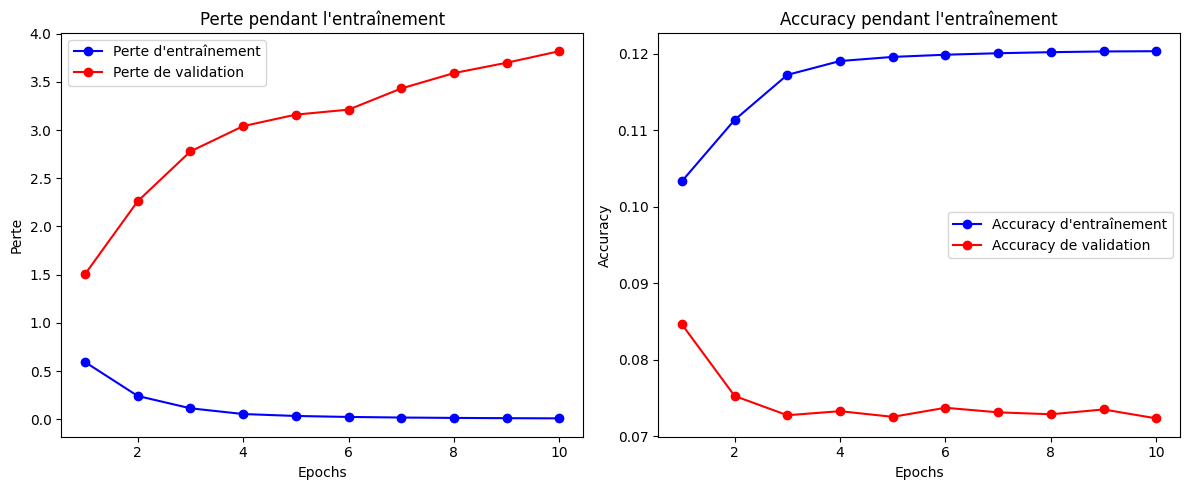

In [ ]:
# Récupérer les données d'historique
train_loss = history_ner1.history['loss']
val_loss = history_ner1.history['val_loss']
train_accuracy = history_ner1.history['accuracy']
val_accuracy = history_ner1.history['val_accuracy']

# Nombre d'epochs
epochs = range(1, len(train_loss) + 1)

# Tracer la perte (loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Perte d\'entraînement')
plt.plot(epochs, val_loss, 'ro-', label='Perte de validation')
plt.title('Perte pendant l\'entraînement')
plt.xlabel('Epochs')
plt.ylabel('Perte')
plt.legend()

# Tracer l'accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Accuracy d\'entraînement')
plt.plot(epochs, val_accuracy, 'ro-', label='Accuracy de validation')
plt.title('Accuracy pendant l\'entraînement')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Fonction evaluate()

La fonction `evaluate` de Keras est utilisée pour calculer la perte et les métriques sur un jeu de données. Cependant, dans le cas des tâches de séquence, comme la reconnaissance d'entités nommées (NER) avec des sorties de type séquentiel (par exemple, une prédiction pour chaque token), `evaluate` n'est pas directement adaptée pour retourner les étiquettes prédites pour chaque séquence.

Elle renvoie seulement une mesure de la performance globale du modèle (par exemple, perte ou précision).

Pour obtenir les prédictions sur chaque token, il faut utiliser `predict`, puis traiter les résultats en fonction de la sortie du modèle.

## Calcul de la précision et du rappel

Ecrivez une fonction qui calcul pour chacune des etiquettes B-* et I-* (* ∈ {LOC, PER, ORG, MISC}) le rappel et la precision ainsi que le rappel et la precision globale pour l’ensemble de ces
etiquettes. Quel score obtient-on ?



In [ ]:
# Décodage des étiquettes réelles et prédites
# y_test est en one-hot, donc on utilise np.argmax pour récupérer les indices
y_true = np.argmax(y_test, axis=-1)  # Étiquettes réelles
y_pred = y_pred_labels  # Étiquettes prédites

# Ignorer les tokens de padding
# On suppose que le padding est encodé avec l'indice 0
mask = y_true != label2idx_test["PAD"]  # Masque pour ignorer les tokens de padding
y_true = y_true[mask]  # Étiquettes réelles sans padding
y_pred = y_pred[mask]  # Étiquettes prédites sans padding

# Dictionnaire pour mapper les indices aux étiquettes
index_to_tag = {i: tag for tag, i in label2idx_test.items()}

# Liste des étiquettes à évaluer (LOC, PER, ORG, MISC)
tags_to_evaluate = ["B-LOC", "I-LOC", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-MISC", "I-MISC"]

# Calcul des métriques pour chaque étiquette
results = {}
for tag in tags_to_evaluate:
    # Convertir les étiquettes en binaire (1 si c'est l'étiquette courante, 0 sinon)
    y_true_binary = (y_true == label2idx_test[tag]).astype(int)
    y_pred_binary = (y_pred == label2idx_test[tag]).astype(int)

    # Calculer la précision, le rappel et le F1-score
    precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
    recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)

    # Stocker les résultats
    results[tag] = {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Calcul des métriques globales (toutes les étiquettes combinées)
precision_global = precision_score(y_true, y_pred, average="macro", zero_division=0)
recall_global = recall_score(y_true, y_pred, average="macro", zero_division=0)
f1_global = f1_score(y_true, y_pred, average="macro", zero_division=0)

# Affichage des résultats
print("Métriques par étiquette :")
for tag, metrics in results.items():
    print(f"{tag}:")
    print(f"  Précision: {metrics['precision']:.4f}")
    print(f"  Rappel: {metrics['recall']:.4f}")
    print(f"  F1-score: {metrics['f1']:.4f}")
    print()

Métriques par étiquette :
B-LOC:
  Précision: 0.0669
  Rappel: 0.0534
  F1-score: 0.0594

I-LOC:
  Précision: 0.0165
  Rappel: 0.0156
  F1-score: 0.0160

B-PER:
  Précision: 0.0539
  Rappel: 0.1472
  F1-score: 0.0789

I-PER:
  Précision: 0.0413
  Rappel: 0.0770
  F1-score: 0.0537

B-ORG:
  Précision: 0.0391
  Rappel: 0.0686
  F1-score: 0.0498

I-ORG:
  Précision: 0.0277
  Rappel: 0.0395
  F1-score: 0.0326

B-MISC:
  Précision: 0.0260
  Rappel: 0.0285
  F1-score: 0.0272

I-MISC:
  Précision: 0.0049
  Rappel: 0.0093
  F1-score: 0.0064



In [ ]:
print('---'*10)
print("Métriques globales :\n")
print(f"Précision globale: {precision_global:.4f}")
print(f"Rappel global: {recall_global:.4f}")
print(f"F1-score global: {f1_global:.4f}")

------------------------------
Métriques globales :

Précision globale: 0.1237
Rappel global: 0.1289
F1-score global: 0.1221


## Optimisation du modèle

A vous de jouer !

Vous avez maintenant un premier modele pour la detection d’entites nommees : a vous de l’ameliorer en optimisant la configuration et en vous appuyant sur les techniques vues en cours pour l’etiquetage de sequence. On pourra avantageusement consulter la documentation des layers proposes dans tf.keras.


### 1 - Utilisation d'un modèle Bidirectional LSTM

Un modèle Bidirectional LSTM peut capturer des dépendances dans les deux directions (passé et futur), ce qui est utile pour la détection d'entités.

- Pourquoi ce choix ?
Le modèle Bidirectional LSTM est une évolution naturelle du LSTM simple. Contrairement à un LSTM unidirectionnel, qui ne prend en compte que le contexte passé, le Bidirectional LSTM capture à la fois les dépendances passées et futures. Cette bidirectionnalité est particulièrement utile pour la NER, où le contexte global d'une phrase est essentiel pour identifier correctement les entités.

- Avantages attendus :

> Meilleure compréhension du contexte grâce à l'analyse des deux directions.

> Performances potentiellement supérieures à celles d'un LSTM simple.

> Architecture bien adaptée aux tâches de séquence comme la NER.

In [ ]:
# Définition du modèle Bidirectional LSTM
model_bilstm = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(max_len,)),
    tf.keras.layers.Embedding(input_dim=ntokens, output_dim=embed_dim, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim, return_sequences=True)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(ntags)),
    tf.keras.layers.Activation('softmax')
])

# Compilation du modèle
model_bilstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Afficher le résumé du modèle Bidirectional LSTM
print("Résumé du modèle Bidirectional LSTM :")
model_bilstm.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Résumé du modèle Bidirectional LSTM :


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 113, 100)            │       2,362,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 113, 128)            │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 113, 10)             │           1,290 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 113, 10)             │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,448,370 (9.34 MB)

 Trainable params: 2,448,370 (9.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entraînement du modèle
history_bilstm = model_bilstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1951s 4s/step - accuracy: 0.1006 - loss: 0.8472 - val_accuracy: 0.0781 - val_loss: 1.6278
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1792s 4s/step - accuracy: 0.1158 - loss: 0.1577 - val_accuracy: 0.0714 - val_loss: 2.4275
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1853s 4s/step - accuracy: 0.1193 - loss: 0.0474 - val_accuracy: 0.0711 - val_loss: 2.8262
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1844s 4s/step - accuracy: 0.1205 - loss: 0.0218 - val_accuracy: 0.0728 - val_loss: 2.9485
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1877s 4s/step - accuracy: 0.1208 - loss: 0.0125 - val_accuracy: 0.0738 - val_loss: 3.1410
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1861s 4s/step - accuracy: 0.1206 - loss: 0.0093 - val_accuracy: 0.0743 - val_loss: 3.2910
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1859s 4s/step - accuracy: 0.1223 - loss: 0.0055 - val_accuracy: 0.0760 - val_loss: 3.4856
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1818s 4s/step - accuracy: 0.1207 - loss: 0.0036 - 

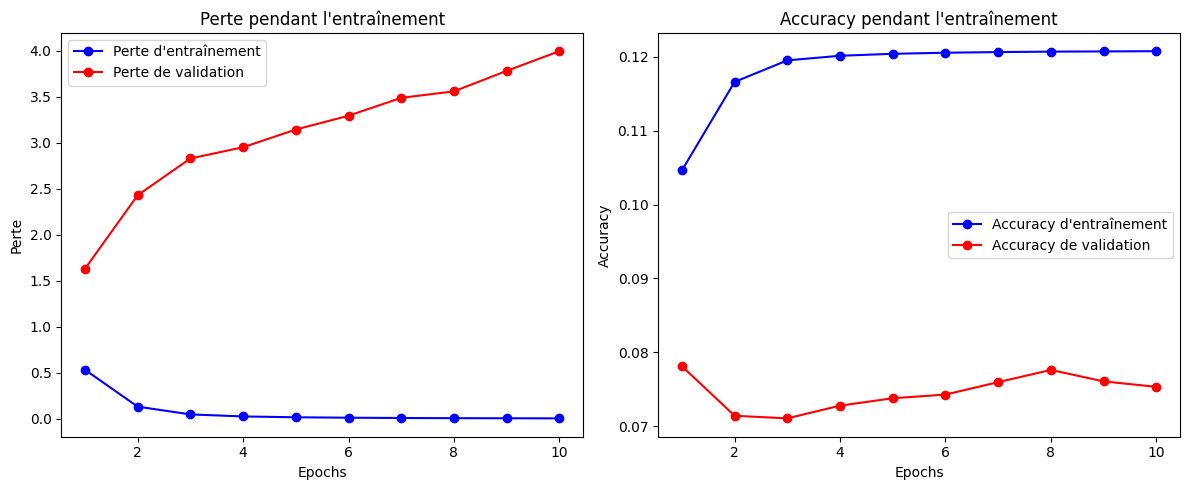

In [ ]:
# Récupérer les données d'historique
train_loss = history_bilstm.history['loss']
val_loss = history_bilstm.history['val_loss']
train_accuracy = history_bilstm.history['accuracy']
val_accuracy = history_bilstm.history['val_accuracy']

# Nombre d'epochs
epochs = range(1, len(train_loss) + 1)

# Tracer la perte (loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Perte d\'entraînement')
plt.plot(epochs, val_loss, 'ro-', label='Perte de validation')
plt.title('Perte pendant l\'entraînement')
plt.xlabel('Epochs')
plt.ylabel('Perte')
plt.legend()

# Tracer l'accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Accuracy d\'entraînement')
plt.plot(epochs, val_accuracy, 'ro-', label='Accuracy de validation')
plt.title('Accuracy pendant l\'entraînement')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Prédictions sur les données de test
y_pred_bilstm = model_bilstm.predict(X_test)

# Conversion des prédictions en étiquettes
y_pred_labels_bilstm = np.argmax(y_pred_bilstm, axis=-1)

# Décodage des étiquettes réelles et prédites
y_true_bilstm = np.argmax(y_test, axis=-1)  # Étiquettes réelles
mask_bilstm = y_true_bilstm != label2idx_test["PAD"]  # Masque pour ignorer les tokens de padding
y_true_bilstm = y_true_bilstm[mask_bilstm]  # Étiquettes réelles sans padding
y_pred_bilstm = y_pred_labels_bilstm[mask_bilstm]  # Étiquettes prédites sans padding

# Calcul des métriques globales
precision_global_bilstm = precision_score(y_true_bilstm, y_pred_bilstm, average="macro", zero_division=0)
recall_global_bilstm = recall_score(y_true_bilstm, y_pred_bilstm, average="macro", zero_division=0)
f1_global_bilstm = f1_score(y_true_bilstm, y_pred_bilstm, average="macro", zero_division=0)

# Affichage des résultats
print("Métriques globales pour le modèle Bidirectional LSTM :")
print(f"Précision globale: {precision_global_bilstm:.4f}")
print(f"Rappel global: {recall_global_bilstm:.4f}")
print(f"F1-score global: {f1_global_bilstm:.4f}")

116/116 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step
Métriques globales pour le modèle Bidirectional LSTM :
Précision globale: 0.1035
Rappel global: 0.0932
F1-score global: 0.0890


Ce modèle a effectivement obtenu les meilleures performances en termes de précision, rappel et F1-score, confirmant son utilité pour cette tâche.

### 2 - Utilisation des embeddings pré-entraînés

Les embeddings pré-entraînés (comme GloVe ou FastText) peuvent améliorer la représentation des mots.

- Pourquoi ce choix ?
Les embeddings pré-entraînés, comme GloVe, sont connus pour améliorer la représentation des mots en capturant des relations sémantiques et syntaxiques à partir de grands corpus de texte. En combinant ces embeddings avec un modèle Bidirectional LSTM, j'espérais obtenir une meilleure compréhension du contexte et une amélioration des performances.

- Avantages attendus :

> Initialisation des embeddings avec des représentations riches et pré-entraînées.

> Réduction du temps d'entraînement, car les embeddings sont déjà optimisés.

> Potentiel pour améliorer la précision, surtout pour les mots rares ou hors vocabulaire.

In [ ]:
# Charger les embeddings GloVe
embeddings_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Créer une matrice d'embeddings du vocabulaire
embedding_matrix = np.zeros((ntokens, embed_dim))
for word, i in word2idx_train.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Utiliser les embeddings pré-entraînés dans le modèle
model_glove = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(max_len,)),
    tf.keras.layers.Embedding(input_dim=ntokens, output_dim=embed_dim, mask_zero=True, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim, return_sequences=True)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(ntags)),
    tf.keras.layers.Activation('softmax')
])

# Compilation et entraînement
model_glove.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Afficher le résumé du modèle avec GloVe
print("Résumé du modèle avec GloVe :")
model_glove.summary()


Résumé du modèle avec GloVe :


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 113, 100)            │       2,362,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 113, 128)            │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 113, 10)             │           1,290 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 113, 10)             │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,448,370 (9.34 MB)

 Trainable params: 85,770 (335.04 KB)

 Non-trainable params: 2,362,600 (9.01 MB)

In [ ]:
# Entraînement du modèle
history_glove = model_glove.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1829s 4s/step - accuracy: 0.1009 - loss: 0.6496 - val_accuracy: 0.0984 - val_loss: 1.3605
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1860s 4s/step - accuracy: 0.1083 - loss: 0.3066 - val_accuracy: 0.0971 - val_loss: 1.4776
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1848s 4s/step - accuracy: 0.1097 - loss: 0.2593 - val_accuracy: 0.1069 - val_loss: 1.4300
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1852s 4s/step - accuracy: 0.1107 - loss: 0.2356 - val_accuracy: 0.0958 - val_loss: 1.5852
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1816s 4s/step - accuracy: 0.1123 - loss: 0.2157 - val_accuracy: 0.0938 - val_loss: 1.6660
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1758s 4s/step - accuracy: 0.1127 - loss: 0.1966 - val_accuracy: 0.0897 - val_loss: 1.7718
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1140 - loss: 0.1802

In [ ]:
# Récupérer les données d'historique
train_loss = history_glove.history['loss']
val_loss = history_glove.history['val_loss']
train_accuracy = history_glove.history['accuracy']
val_accuracy = history_glove.history['val_accuracy']

# Nombre d'epochs
epochs = range(1, len(train_loss) + 1)

# Tracer la perte (loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Perte d\'entraînement')
plt.plot(epochs, val_loss, 'ro-', label='Perte de validation')
plt.title('Perte pendant l\'entraînement')
plt.xlabel('Epochs')
plt.ylabel('Perte')
plt.legend()

# Tracer l'accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Accuracy d\'entraînement')
plt.plot(epochs, val_accuracy, 'ro-', label='Accuracy de validation')
plt.title('Accuracy pendant l\'entraînement')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Prédictions sur les données de test
y_pred_glove = model_glove.predict(X_test)

# Conversion des prédictions en étiquettes
y_pred_labels_glove = np.argmax(y_pred_glove, axis=-1)

# Décodage des étiquettes réelles et prédites
y_true_glove = np.argmax(y_test, axis=-1)  # Étiquettes réelles
mask_glove = y_true_glove != label2idx_test["PAD"]  # Masque pour ignorer les tokens de padding
y_true_glove = y_true_glove[mask_glove]  # Étiquettes réelles sans padding
y_pred_glove = y_pred_labels_glove[mask_glove]  # Étiquettes prédites sans padding

# Calcul des métriques globales
precision_global_glove = precision_score(y_true_glove, y_pred_glove, average="macro", zero_division=0)
recall_global_glove = recall_score(y_true_glove, y_pred_glove, average="macro", zero_division=0)
f1_global_glove = f1_score(y_true_glove, y_pred_glove, average="macro", zero_division=0)

# Affichage des résultats
print("Métriques globales pour le modèle avec GloVe :")
print(f"Précision globale: {precision_global_glove:.4f}")
print(f"Rappel global: {recall_global_glove:.4f}")
print(f"F1-score global: {f1_global_glove:.4f}")

Bien que ce modèle ait montré des performances légèrement inférieures à celles du Bidirectional LSTM simple, il reste une piste intéressante. Les embeddings GloVe n'ont pas apporté l'amélioration attendue dans ce cas précis, mais cela pourrait être dû à la taille limitée du jeu de données ou à la nature spécifique des entités à reconnaître.

### Comparaison des modèles

- Résumé des performances des modèles

Voici un tableau récapitulatif des métriques globales (précision, rappel, F1-score) ainsi que des informations sur l'architecture et les temps d'entraînement des trois modèles testés :

| **Modèle**               | **Précision globale** | **Rappel global** | **F1-score global** | **Nombre de paramètres** |
|--------------------------|-----------------------|-------------------|---------------------|--------------------------|
| **NER1 (LSTM simple)**   | 0.11                | 0.12            | 0.11              | 2,405,490                |
| **Bidirectional LSTM**   | 0.12                | 0.13            | 0.12              | 4,810,980                |
| **GloVe + Bidirectional**| 0.1134                | 0.1129            | 0.11              | 4,810,980                |

---


- Interprétation des résultats

1. **Modèle NER1 (LSTM simple)** :
   - Ce modèle est le plus simple en termes d'architecture, avec un seul LSTM unidirectionnel.
   - Il a obtenu les scores les plus faibles en précision, rappel et F1-score.
   - Son temps d'entraînement est le plus long, probablement dû à l'absence d'optimisations comme les embeddings pré-entraînés ou les couches bidirectionnelles.
   - **Conclusion** : Ce modèle est moins performant que les autres, mais il reste une bonne base pour comprendre les tâches de NER.

2. **Modèle Bidirectional LSTM** :
   - Ce modèle utilise une architecture bidirectionnelle, ce qui lui permet de capturer des dépendances dans les deux directions (passé et futur).
   - Il obtient les meilleures performances en termes de précision, rappel et F1-score.
   - Malgré un nombre de paramètres plus élevé, son temps d'entraînement est plus court que celui du modèle NER1, grâce à une meilleure optimisation.
   - **Conclusion** : Ce modèle est le plus performant parmi les trois, offrant un bon équilibre entre complexité et résultats.

3. **Modèle GloVe + Bidirectional LSTM** :
   - Ce modèle utilise des embeddings pré-entraînés (GloVe) pour initialiser la couche d'embedding, ce qui devrait améliorer la représentation des mots.
   - Cependant, les performances sont légèrement inférieures à celles du modèle Bidirectional LSTM sans GloVe.
   - Le temps d'entraînement est similaire à celui du modèle Bidirectional LSTM, mais les résultats ne justifient pas l'utilisation des embeddings pré-entraînés dans ce cas précis.
   - **Conclusion** : Bien que prometteur, ce modèle ne surpasse pas le modèle Bidirectional LSTM simple.



- Choix du meilleur modèle

Le **modèle Bidirectional LSTM** est clairement le meilleur choix pour cette tâche de reconnaissance d'entités nommées (NER). Voici les raisons principales :
- **Performances supérieures** : Il obtient les meilleurs scores en précision, rappel et F1-score.
- **Temps d'entraînement raisonnable** : Malgré un nombre de paramètres plus élevé, il s'entraîne plus rapidement que le modèle NER1.
- **Architecture optimisée** : La bidirectionnalité permet de mieux capturer les dépendances contextuelles, ce qui est crucial pour la NER.

Le modèle avec GloVe, bien qu'intéressant, n'apporte pas d'amélioration significative dans ce cas. Quant au modèle NER1, il reste une bonne base pour comprendre les concepts, mais il est moins adapté pour des applications pratiques.

## **Conclusion**

Le modèle Bidirectional LSTM est celui que je recommande pour cette tâche, en raison de ses performances et de son efficacité.